In [1]:
import torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
transform = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root='',download=False,train=True, transform=transform)

In [7]:
test_data = datasets.MNIST(root='',download=False,train=False, transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [11]:
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)


In [12]:
for i, (X_train,Y_train) in enumerate(train_data):
    break

In [13]:
X_train.shape

torch.Size([1, 28, 28])

In [14]:
X = X_train.view(1,1,28,28)

In [15]:
x = F.relu(conv1(X))

In [16]:
x.shape

torch.Size([1, 6, 26, 26])

In [17]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 13, 13])

In [18]:
x = F.relu(conv2(x))

In [19]:
x.shape

torch.Size([1, 16, 11, 11])

In [20]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(5*5*16,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,16*5*5)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
        
        

In [22]:
torch.manual_seed(41)

In [23]:
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 2
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    tr_correct = 0
    ts_correct = 0
    
    for b, (X_train,Y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred,Y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == Y_train).sum()
        
        tr_correct += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
            
        
    train_losses.append(loss)
    train_correct.append(tr_correct)
    
    with torch.no_grad():
        for b,(X_test,Y_test) in  enumerate(train_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            ts_correct += (predicted == Y_test).sum()
    loss = criterion(y_val,Y_test)
    test_losses.append(loss)
    test_correct.append(ts_correct)

current_time = time.time()
total_time = current_time - start_time
print(f'Training Took: {total_time/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.002947667147964239
Epoch: 0 Batch: 1200 Loss: 0.02413235232234001
Epoch: 0 Batch: 1800 Loss: 0.006165817845612764
Epoch: 0 Batch: 2400 Loss: 0.10973528772592545
Epoch: 0 Batch: 3000 Loss: 0.001308317994698882
Epoch: 0 Batch: 3600 Loss: 0.0033021587878465652
Epoch: 0 Batch: 4200 Loss: 0.36500343680381775
Epoch: 0 Batch: 4800 Loss: 0.09200149774551392
Epoch: 0 Batch: 5400 Loss: 0.011152466759085655


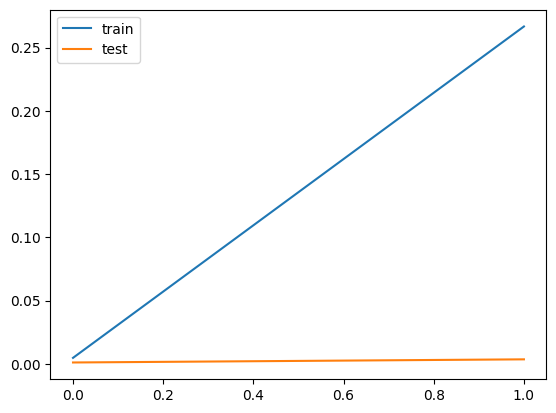

In [27]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="train")
plt.plot(test_losses,label="test")
plt.legend()

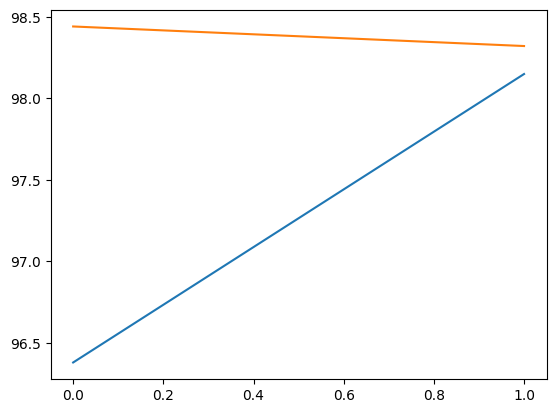

In [28]:
plt.plot([t/600 for t in train_correct],label="train")
plt.plot([t/600 for t in test_correct],label="test")

In [29]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [30]:
with torch.no_grad():
    correct = 0
    for X_test, Y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == Y_test).sum()
        

In [31]:
correct.item()/len(test_data)*100

97.86

In [32]:
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [35]:
x1 = test_data[4143][0].reshape(28,28)

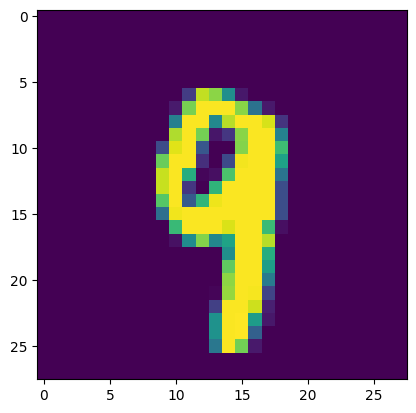

In [36]:
plt.imshow(x1)

In [38]:
model.eval()
with torch.no_grad():
    new_pred = model(x1.view(1,1,28,28))

In [39]:
new_pred

tensor([[-1.2982e+01, -1.1615e+01, -1.3904e+01, -8.8634e+00, -8.0887e+00,
         -1.1108e+01, -1.8328e+01, -9.1008e+00, -9.7626e+00, -6.4507e-04]])

In [40]:
new_pred.argmax()

tensor(9)